In [16]:
%matplotlib notebook

In [17]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy import stats
import statsmodels.api as sm

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats

In [18]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig1_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

# dose response

In [19]:
filename = 'Fig1EF_attP1'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 1E and 1F 
which shows response of control animals with UAS-Chrimson in su(Hw)attP1
at 8uW/mm2, 47uW/mm2 and 72uW/mm2.

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 3. These are: 8uW/mm2, 47uW/mm2 and 72uW/mm2 

5th dimension is 1.


<IPython.core.display.Javascript object>


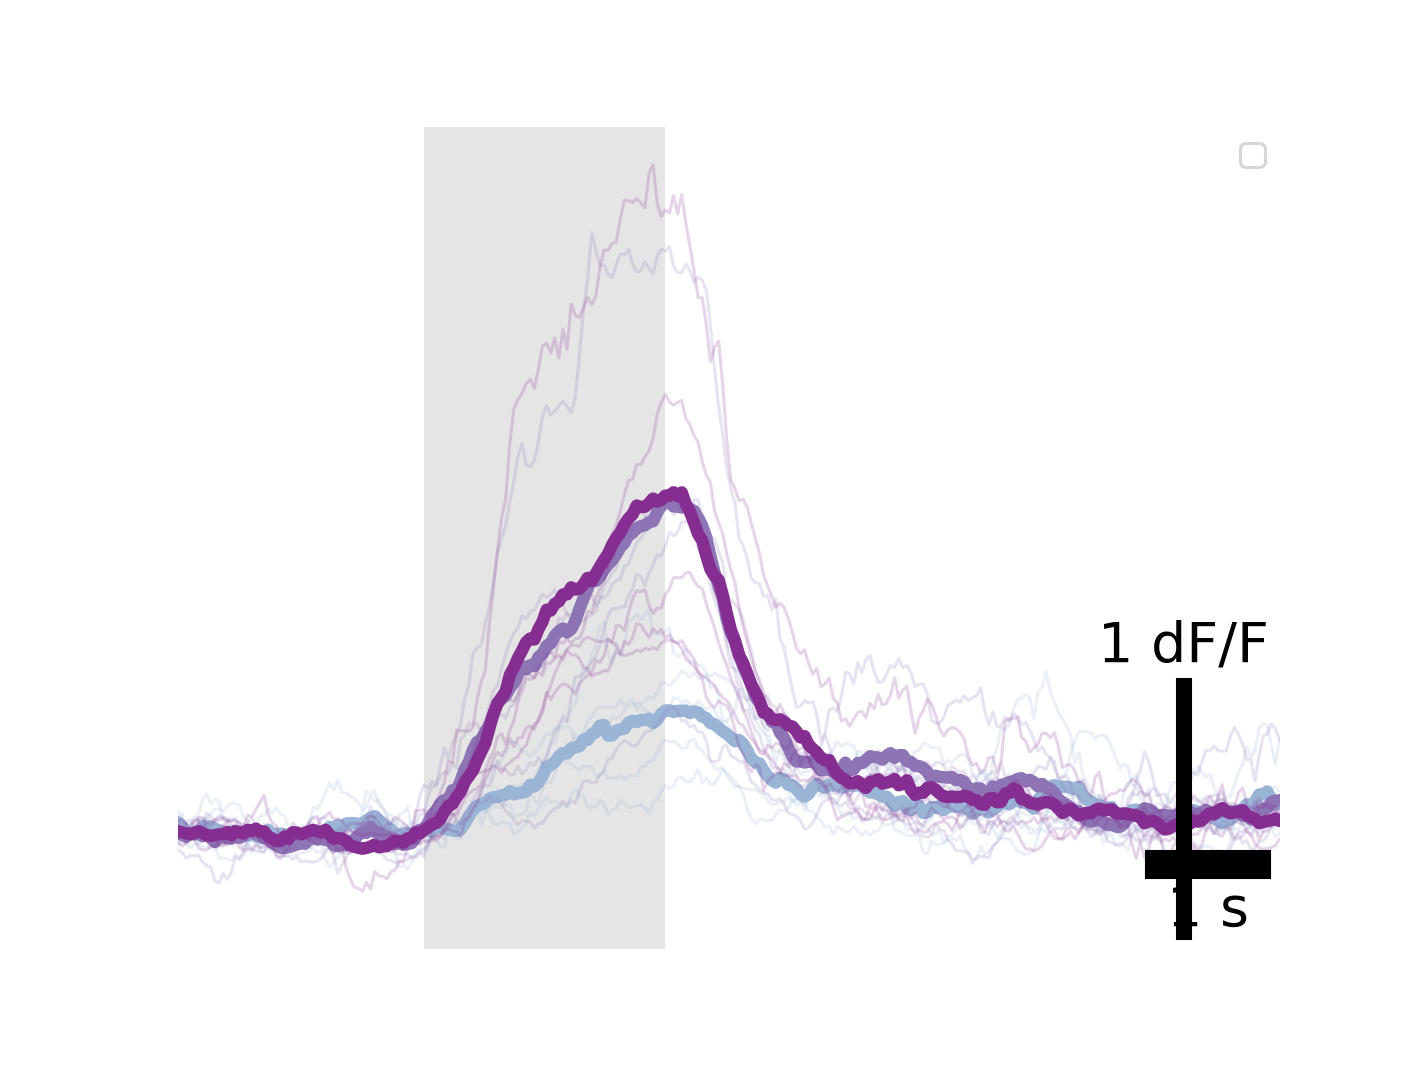

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [20]:
# Define colors used for this plot
start = 0.4
stop = 0.8
number_of_lines= data.shape[3]
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [matplotlib.cm.BuPu(x) for x in cm_subsection ]
colors = np.array(colors)

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Here we have only one group
group = 0

for stim_intensity in range(3):

    ax.plot(data[:,0,0,stim_intensity,group], median_per_animal[:,:,stim_intensity,group], lw=1, zorder=1, 
            color=colors[stim_intensity], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity,group], np.mean(median_per_animal[:,:,stim_intensity,group], axis=1), 
            lw=4, zorder=1, color=colors[stim_intensity])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig1_E.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [21]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


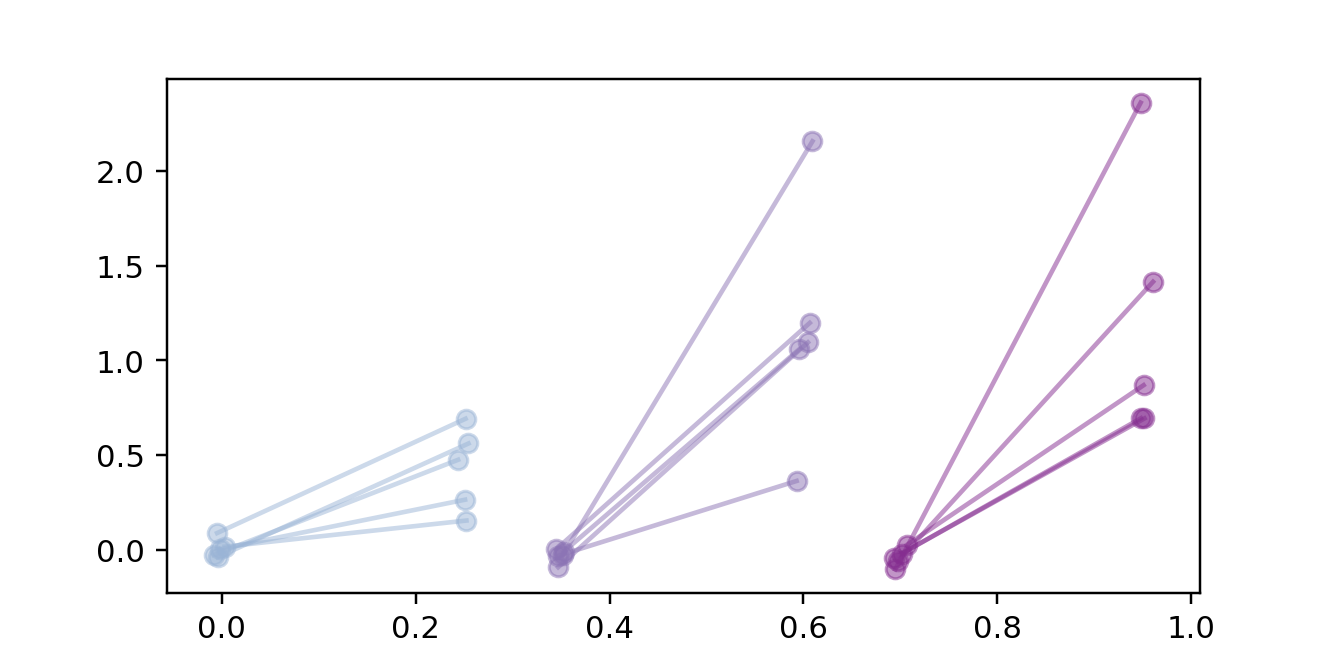

In [22]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=0, 
                           color=colors[0], start_x_position=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=1, 
                           color=colors[1], start_x_position=0.35)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=2, 
                           color=colors[2], start_x_position=0.7)

savename = 'Fig1_F.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [23]:
p_values=[]

# median_before_stim.shape
# (5, 3, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values) # 8 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,1,0], median_before_stim[:,1,0], p_values) # 47 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,2,0], median_before_stim[:,2,0], p_values) # 72 uW/mm2

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.4044837866807331
T-Test
TtestResult(statistic=4.467623862940523, pvalue=0.011094950311599206, df=4)


lilliefors: 0.1456542324028035
T-Test
TtestResult(statistic=4.21806480975938, pvalue=0.01349852089825929, df=4)


lilliefors: 0.15152360220947536
T-Test
TtestResult(statistic=3.7239197899205876, pvalue=0.02040467008857925, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.011094950311599206, current alpha: 0.016666666666666666
significantly different with:
current p: 0.01349852089825929, current alpha: 0.025
significantly different with:
current p: 0.02040467008857925, current alpha: 0.05


# Export Stats

In [24]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]],
        [median_during_stim[:,1,0], median_before_stim[:,1,0]],
        [median_during_stim[:,2,0], median_before_stim[:,2,0]]
       ]

label_list_stat_export = [['During, 8uW/mm2', 'Before, 8uW/mm2'],
                          ['During, 47uW/mm2', 'Before, 47uW/mm2'],
                          ['During, 72uW/mm2', 'Before, 72uW/mm2']]
savename = 'Fig_1F'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

              Group  n      mean    median       STD       SEM  \
0   During, 8uW/mm2  5  0.429012  0.474818  0.195822  0.087574   
1   Before, 8uW/mm2  5  0.007411  0.002069  0.044753  0.020014   
2  During, 47uW/mm2  5  1.174896  1.095408  0.573914  0.256662   
3  Before, 47uW/mm2  5 -0.033020 -0.029585  0.032435  0.014506   
4  During, 72uW/mm2  5  1.207098  0.869119  0.635590  0.284245   
5  Before, 72uW/mm2  5 -0.041131 -0.042544  0.042705  0.019098   

                             95% CI on the mean  DOF statistical test  \
0       (0.1571680399210204, 0.700856389683703)  4.0       T-test rel   
1   (-0.05471711984792019, 0.06953816612203727)  NaN              NaN   
2     (0.37817515655485245, 1.9716172385195763)  4.0       T-test rel   
3  (-0.07804768266715861, 0.012007324740814576)  NaN              NaN   
4       (0.32475743487751063, 2.08943899465019)  4.0       T-test rel   
5  (-0.10041569143090234, 0.018153493663287168)  NaN              NaN   

   t-statistic   p-value 

# Figure 1 B and D

This uses the color defined above, that's why it is run after the dose response

In [25]:
filename = 'Fig1BC_attP1_ATR'
# read the numpy array
data_ATR = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 1E and 1F 
which shows ATR+ and ATR- with stimulus duration of 2s and 
stimulus intensity of 47uW/mm2

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 1 

5th dimension is 2. The first contains ATR- data, the second contains ATR+ data.


<IPython.core.display.Javascript object>


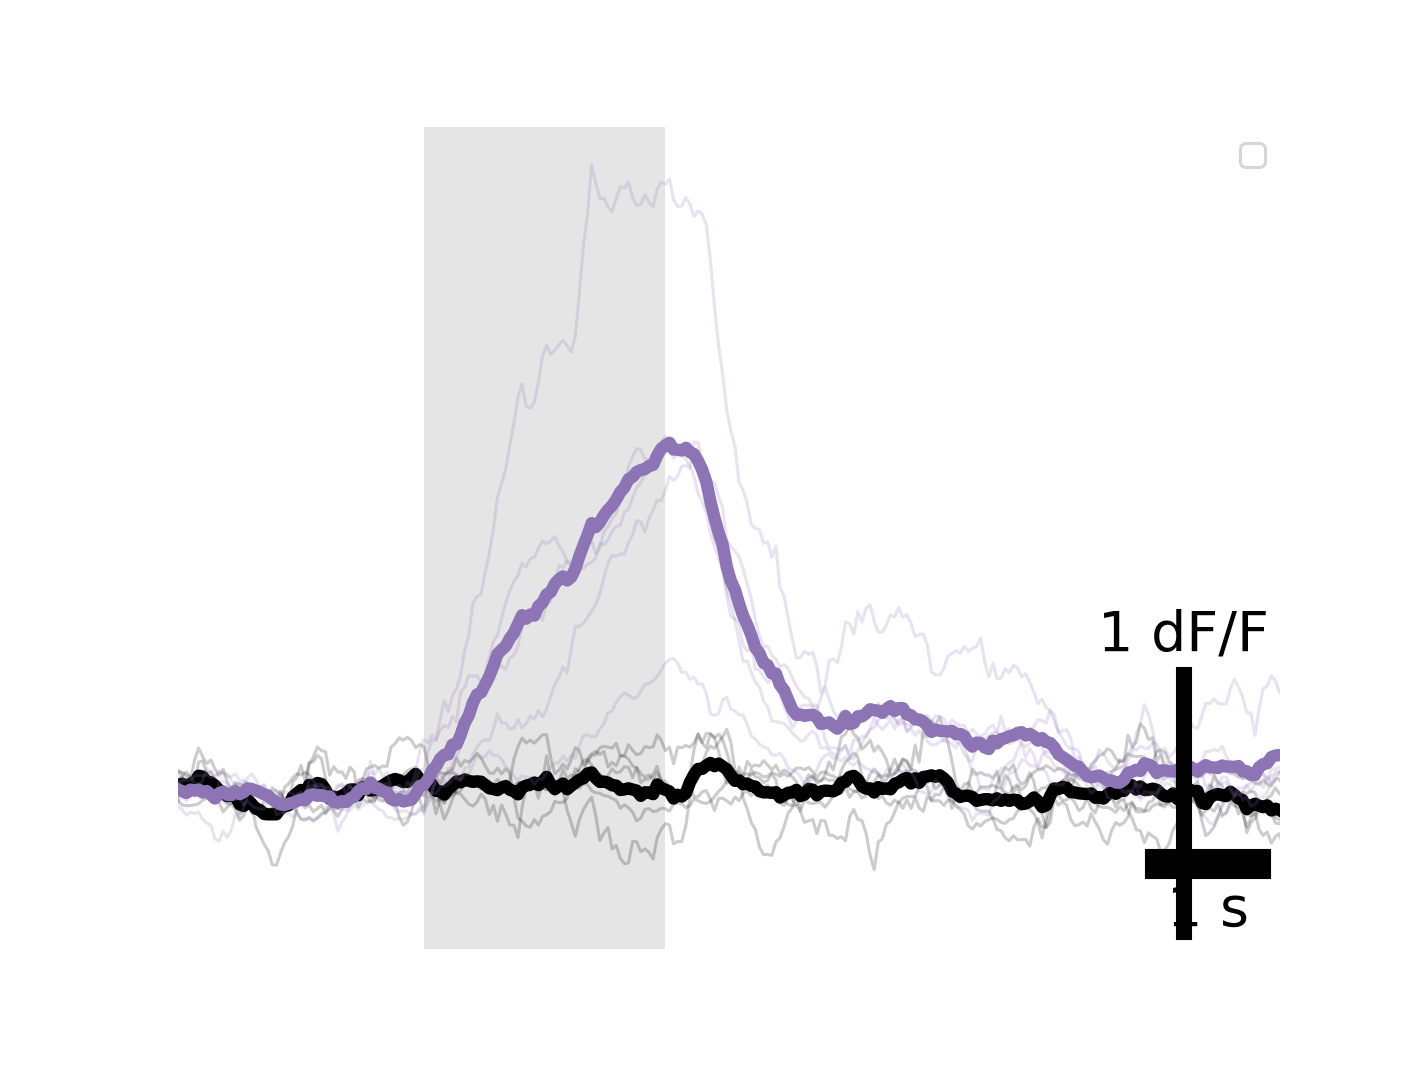

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [26]:
# Prepare the raw data for plotting
median_per_animal_ATR = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data_ATR)
# Here stim_intensity is always 0
stim_intensity_ATR = 0

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Important for plotting: For ATR- we want to use black! 
colors_2 = ['black',
            colors[1],
            ]

for group in range(2):

    ax.plot(data_ATR[:,0,0,stim_intensity_ATR, group], median_per_animal_ATR[:,:,stim_intensity_ATR, group], 
            lw=1, zorder=1, color=colors_2[group], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data_ATR[:,0,0,stim_intensity_ATR, group], 
            np.mean(median_per_animal_ATR[:,:,stim_intensity_ATR, group], axis=1), 
            lw=4, zorder=1, color=colors_2[group])

# Plot stimulus
start_stim = np.where(data_ATR[:, 1, 0, stim_intensity_ATR, 0] > 0.1)[0][0]
stop_stim = np.where(data_ATR[:, 1, 0, stim_intensity_ATR, 0] > 0.1)[0][-1]
ax.axvspan(data_ATR[start_stim, 0, 0, stim_intensity_ATR, 0],
           data_ATR[stop_stim, 0, 0, stim_intensity_ATR, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig1_B.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [27]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim_ATR = np.median(median_per_animal_ATR[before_start_index:start_stim, :, :],axis=0)
median_during_stim_ATR = np.median(median_per_animal_ATR[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


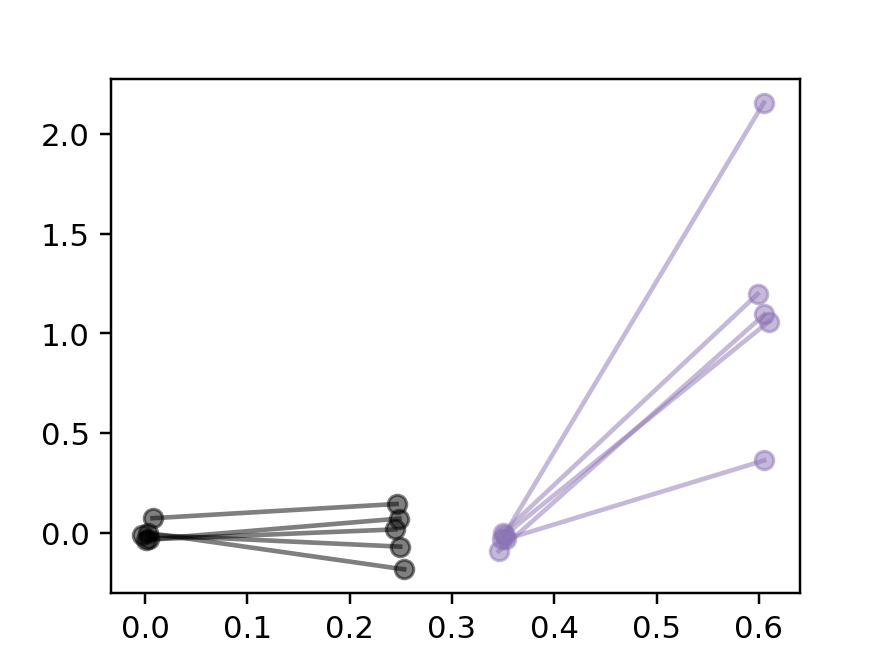

In [28]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim_ATR, median_during_stim_ATR, 
                                       light_intensity=stim_intensity_ATR, 
                                       color=colors_2[0], start_x_position=0, group=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim_ATR, median_during_stim_ATR, 
                                       light_intensity=stim_intensity_ATR,
                                       color=colors_2[1], start_x_position=0.35, group=1)

savename = 'Fig1_C.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [29]:
p_values=[]

# median_before_stim_ATR.shape
# (5, 1, 2) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim_ATR[:,0,0], median_before_stim_ATR[:,0,0], p_values) # ATR-
shared_func.pairwise_t_tests(median_during_stim_ATR[:,0,1], median_before_stim_ATR[:,0,1], p_values) # ATR+

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.26909305762312996
T-Test
TtestResult(statistic=-0.060952785510373315, pvalue=0.9543207598863155, df=4)


lilliefors: 0.1456542324028035
T-Test
TtestResult(statistic=4.21806480975938, pvalue=0.01349852089825929, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.01349852089825929, current alpha: 0.025
NOT DIFFERENT!
current p: 0.9543207598863155, current alpha: 0.05


In [30]:
data = [[median_during_stim_ATR[:,0,0], median_before_stim_ATR[:,0,0]],
        [median_during_stim_ATR[:,0,1], median_before_stim_ATR[:,0,1]]
       ]

label_list_stat_export = [['During, ATR-', 'Before, ATR-'],
                          ['During, ATR+', 'Before, ATR+']]
savename = 'Fig_1C'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

          Group  n      mean    median       STD       SEM  \
0  During, ATR-  5 -0.004440  0.016430  0.113747  0.050869   
1  Before, ATR-  5 -0.001223 -0.009783  0.039202  0.017532   
2  During, ATR+  5  1.174896  1.095408  0.573914  0.256662   
3  Before, ATR+  5 -0.033020 -0.029585  0.032435  0.014506   

                             95% CI on the mean  DOF statistical test  \
0    (-0.1623467118303709, 0.15346665698118453)  4.0       T-test rel   
1   (-0.05564402435910679, 0.05319732075010957)  NaN              NaN   
2     (0.37817515655485245, 1.9716172385195763)  4.0       T-test rel   
3  (-0.07804768266715861, 0.012007324740814576)  NaN              NaN   

   t-statistic   p-value  Holm-Bonferroni corrected p-value significant  
0    -0.060953  0.954321                           0.954321          NO  
1          NaN       NaN                                NaN         NaN  
2     4.218065  0.013499                           0.026997         YES  
3          NaN       NaN   